# Fake Job Predictions
#### By Sara Bardají, Sergi Bech, Maria Magdalena Pol and Celine Odding

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

import nltk
import string
import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarabase/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sarabase/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Read data

In [3]:
df = pd.read_csv('inclassfakejobs/train.csv')
df_sub = pd.read_csv('inclassfakejobs/test.csv')

In [4]:
df.head(3)

,Id,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,required_doughnuts_comsumption,fraudulent
0,0,5737,Jr. Business Analyst & Quality Analyst (entry...,"US, NJ, PISCATAWAY",NaN,NaN,NaN,"Duration: Full time / W2Location: Piscataway,N...",What we require:-- Masters degree in Computers...,NaN,0,0,0,Full-time,Entry level,Master's Degree,Financial Services,Finance,-0.410911,0
1,1,7107,English Teacher Abroad,"US, PA, Scranton",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,NaN,Bachelor's Degree,Education Management,NaN,-0.163785,0
2,2,11979,SQL Server Database Developer Job opportunity ...,"US, IL, Barrington",NaN,90000-100000,We are an innovative personnel-sourcing firm w...,Position : SQL Server Database DeveloperJob Lo...,Position : SQL Server Database DeveloperJob Lo...,Benefits - FullBonus Eligible - Yes,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,-0.244369,0


In [5]:
print("The dataset is composed of %i sample with %i features." % (df.shape[0], df.shape[1]))

The dataset is composed of 10728 sample with 20 features.


## Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10728 entries, 0 to 10727
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Id                              10728 non-null  int64  
 1   job_id                          10728 non-null  int64  
 2   title                           10728 non-null  object 
 3   location                        10523 non-null  object 
 4   department                      3719 non-null   object 
 5   salary_range                    1709 non-null   object 
 6   company_profile                 8766 non-null   object 
 7   description                     10727 non-null  object 
 8   requirements                    9099 non-null   object 
 9   benefits                        6360 non-null   object 
 10  telecommuting                   10728 non-null  int64  
 11  has_company_logo                10728 non-null  int64  
 12  has_questions                   

Observe there are a lot of features of type object, in this case text, so it is important to think how we are going to preprocess this data. Notice there is also some features with a high percentage of null data.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10728.0,5363.500000,3097.051178,0.000000,2681.750000,5363.500000,8045.250000,10727.000000
job_id,10728.0,8967.278523,5149.962766,1.000000,4490.500000,9046.500000,13422.250000,17878.000000
telecommuting,10728.0,0.042785,0.202382,0.000000,0.000000,0.000000,0.000000,1.000000
has_company_logo,10728.0,0.798005,0.401507,0.000000,1.000000,1.000000,1.000000,1.000000
has_questions,10728.0,0.488535,0.499892,0.000000,0.000000,0.000000,1.000000,1.000000
required_doughnuts_comsumption,10728.0,0.043313,0.367068,-1.131903,-0.195022,0.014018,0.236417,1.883086
fraudulent,10728.0,0.046048,0.209598,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
df.duplicated().sum()
#There are no duplicate rows

0

### Missing Values

In [9]:
((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False)

salary_range                      84.069724
department                        65.333706
required_education                45.684191
benefits                          40.715884
required_experience               39.513423
function                          36.073826
industry                          27.395600
employment_type                   19.183445
company_profile                   18.288591
requirements                      15.184564
location                           1.910887
description                        0.009321
Id                                 0.000000
required_doughnuts_comsumption     0.000000
telecommuting                      0.000000
has_questions                      0.000000
has_company_logo                   0.000000
job_id                             0.000000
title                              0.000000
fraudulent                         0.000000
dtype: float64

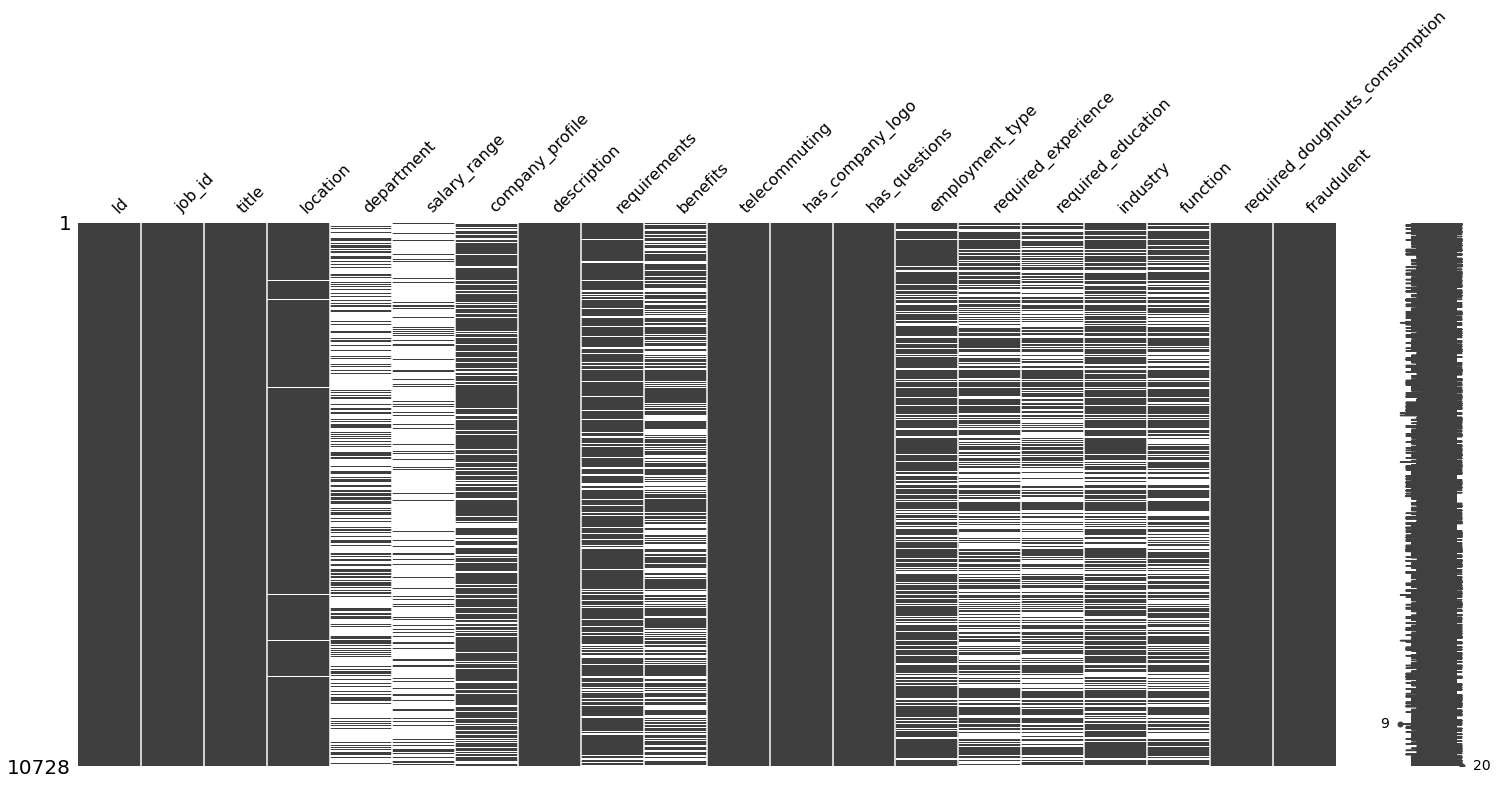

In [10]:
msno.matrix(df)
plt.show()

Notice the features with the most missing values are:
* salary_range
* department
* required_education
* benefits
* required_experience
* function
* industry

### Data distribution

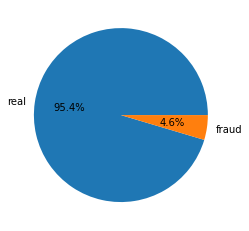

In [11]:
distribution = df['fraudulent'].value_counts()
plt.pie([distribution[0],distribution[1]],labels=["real","fraud"], autopct='%1.1f%%');

The data is clearly unbalanced there are a lot more samples of non-fraudulent jobs than of fraudulent ads.

### Correlation Matrix

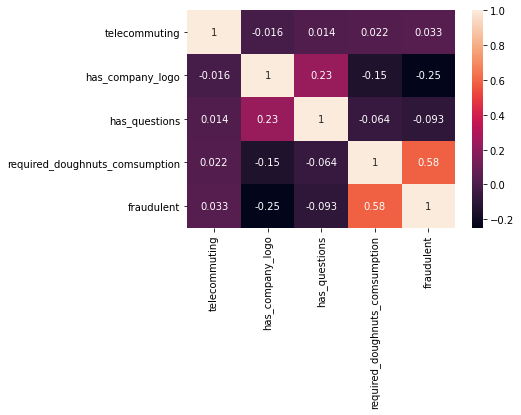

In [12]:
sns.heatmap(df[["telecommuting","has_company_logo","has_questions","required_doughnuts_comsumption","fraudulent"]].corr(),annot=True);

The only feature with a high correlation with the label is doughnut consumption. However, this feature is weird.

### Doughnut consumption feature distribution

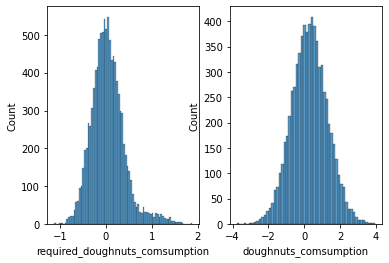

In [13]:
#Let's check the distribution of the varialbe doghnouts consumption
fig, axs = plt.subplots(ncols=2)
sns.histplot(df, x="required_doughnuts_comsumption", ax=axs[0])
sns.histplot(df_sub, x="doughnuts_comsumption", ax=axs[1])
plt.show()

### Drop unwanted features

In [14]:
#Drop features that are not wanted or that have a high percentage of missing values
df = df.drop(columns=['job_id', 'Id', 'salary_range', 'department', 'benefits', 'required_doughnuts_comsumption'])
df_sub = df_sub.drop(columns=['job_id', 'Id', 'salary_range', 'department', 'benefits', 'doughnuts_comsumption'])

## Data Cleaning

### Missing Values

We will treat missing values in two different ways:
- If the missing value corresponds to a long text feature, we substitute the nan for an empty string.
- If the missing value corresponds to a categorical feature (such as emplyment_type, required_education and required_experience), we substitute the nan for "Not Specified". 

In [15]:
#filling null values, 'Not Applicable' and 'Unspecified' with 'Not Specified'
df.fillna(' ', inplace=True)
df = df.replace(['Not Applicable','Unspecified'],' ')
df['employment_type'] = df['employment_type'].replace(' ', 'Not Specified')
df['required_education'] = df['required_education'].replace(' ', 'Not Specified')
df['required_experience'] = df['required_experience'].replace(' ', 'Not Specified')

df_sub.fillna(' ', inplace=True)
df_sub = df_sub.replace(['Not Applicable','Unspecified'],' ')
df_sub['employment_type'] = df_sub['employment_type'].replace(' ', 'Not Specified')
df_sub['required_education'] = df_sub['required_education'].replace(' ', 'Not Specified')
df_sub['required_experience'] = df_sub['required_experience'].replace(' ', 'Not Specified')

In [16]:
df.isna().sum()

title                  0
location               0
company_profile        0
description            0
requirements           0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

### Text features

We will treat all text features as one, by joining all text features and dropping the features that contain the data individually.
Furthermore, once the text is all together, we will preprocess it, taking care of punctuation, removing special characters, urls and phone numbers, and using a Lemmatizer to convert words into their stem word.

In [17]:
text_features = ['title', 'company_profile', 'description', 'requirements', 'industry', 'function', 'location']
df["text_feature"] = ""
df_sub["text_feature"] = ""
for col in text_features:
    df["text_feature"]= df["text_feature"]+" "+ df[col]
    df_sub["text_feature"]= df_sub["text_feature"]+" "+ df_sub[col]
    
df = df.drop(columns=text_features)
df_sub = df_sub.drop(columns=text_features)

In [18]:
df["text_feature"].iloc[0]

'  Jr. Business Analyst & Quality Analyst (entry level)   Duration: Full time / W2Location: Piscataway,NJJob description: BA/QA We are looking to hire resources for our Financial &amp; Health care clients.Candidate should have knowledge or experience in BA Process,QA Testing, Junior or entry level candidates with BA/QA skills are encouraged to apply.Candidates Qualification: Masters Degree in Computer Science, Engineering or similar field.* Knowledge of BA and QA* Knowledge of Databases like Oracle and SQL.* Excellent communication skills.* Must Have a positive attitude.If interested please send me updated Resume with below details :Full Name :Email Id :Phone # &amp; Alternate Phone :Current Location &amp; Address :Relocation Preference :Availability :Visa Status :Expected Rate / Salary :--&gt; Please send your visa scan copy along with above details. So that I will forward your resume along with these details &amp; visa copy to my HR team they will contact with you sortrly.Please feel

### Text pre-processing

In [19]:
from nltk.stem import WordNetLemmatizer 

def text_cleaning(text):
    
    obj = re.compile(r"(#URL.*#)")
    text = obj.sub(r" ", text)
    
    obj = re.compile(r"#PHONE.*#")
    text = obj.sub(r" ", text)
    
    text = text.lower() #text to lowercase
    
    text = re.sub(r'\d+', ' ', text) #remove digits
    
    translator = str.maketrans(' ', ' ', string.punctuation) #remove punctuation
    text = text.translate(translator)
    
    text = " ".join(text.split()) #remove whitespaces
    
    obj = re.compile(r"<.*?>")    #remove html tags
    text = obj.sub(r" ",text)
    
    obj = re.compile(r"https://\S+|http://\S+")    #remove url
    text = obj.sub(r" ",text)
    
    obj = re.compile(r"_+")     #remove underscore
    text = obj.sub(r" ",text)
    
    obj = re.compile(r"\s\w\s")   #remove single character
    text = obj.sub(r" ",text)
    
    stop_words = set(stopwords.words("english"))

    #stemmer = SnowballStemmer("english")
    #text = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    
    return " ".join(text)

In [20]:
df["text_feature"] = df["text_feature"].apply(text_cleaning)
df_sub["text_feature"] = df_sub["text_feature"].apply(text_cleaning)

In [21]:
text_cleaning(df['text_feature'].iloc[0])

'jr business analyst quality analyst entry level duration full time location piscatawaynjjob description baqa looking hire resource financial amp health care clientscandidate knowledge experience ba processqa testing junior entry level candidate baqa skill encouraged applycandidates qualification master degree computer science engineering similar field knowledge ba qa knowledge database like oracle sql excellent communication skill must positive attitudeif interested please send updated resume detail full name email id phone amp alternate phone current location amp address relocation preference availability visa status expected rate salary gt please send visa scan copy along detail forward resume along detail amp visa copy hr team contact sortrlyplease feel free call question require master degree computer science information technologymba candidate willing relocates new jersey excellent communication skill quick learner ability adapting new technology financial service finance nj pisc

### One Hot Encode variables

The variables we are going to one hot encode are:
* required_experience
* required_education
* eployment_type

In [22]:
df = pd.get_dummies(data=df, columns=['required_experience'])
df = pd.get_dummies(data=df, columns=['required_education'])
df = pd.get_dummies(data=df, columns=['employment_type'])



df_sub = pd.get_dummies(data=df_sub, columns=['required_experience'])
df_sub = pd.get_dummies(data=df_sub, columns=['required_education'])
df_sub = pd.get_dummies(data=df_sub, columns=['employment_type'])

## Models

In [28]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import scipy as sp

from sklearn.linear_model import SGDClassifier
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [29]:
y = df["fraudulent"]
X = df.drop(["fraudulent"], axis=1)

In [30]:
X_train,X_val,y_train,y_val=train_test_split(X,y.T,test_size=0.20, random_state=42)

print("Training size: ", X_train.shape)
print("Validation size: ", X_val.shape)

Training size:  (8582, 30)
Validation size:  (2146, 30)


### Vectorize the data

We will use a vectorizer to preprocess our text feature since we can't directly fit the model with them.

In [31]:
vectorizer = TfidfVectorizer(strip_accents='unicode',
                       analyzer='word',
                       ngram_range=(1, 4),
                       smooth_idf=True,
                        max_features=15000,
                       sublinear_tf=True)

vectorizer.fit(X_train['text_feature'])

# Transform training
text_vector = vectorizer.transform(X_train['text_feature'])
rest_train = X_train.drop(columns=['text_feature'])
X_train = sp.sparse.hstack((text_vector, rest_train))

# Transform validation
text_vector = vectorizer.transform(X_val['text_feature'])
rest_val = X_val.drop(columns=['text_feature'])
X_val = sp.sparse.hstack((text_vector, rest_val))

### Apply PCA
Apply PCA to reduce the dimension of the data.

In [32]:
pca = PCA(n_components=0.95)
pca.fit(X_train.toarray())

#Transform training
X_train = pca.transform(X_train.toarray())
#Transform validation
X_val = pca.transform(X_val.toarray())

### Hyperparameter tuning

In [33]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_f1_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation f1_score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_f1_score'][candidate],
                  results['std_test_f1_score'][candidate]))
            print("Mean validation accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_accuracy'][candidate],
                  results['std_test_accuracy'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### Search for best parameters for SVM model

In [36]:
clf = svm.SVC()

parameters = {'C': [10,11,12,13], 
              'gamma': [0.10,0.13,0.15,0.18],
              'kernel': ['rbf'],
             'class_weight': [None, 'balanced']}

scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score)}

grid_search_tune = GridSearchCV(clf, parameters, cv=3, n_jobs=4, verbose=1, scoring=scoring, refit=False)
grid_search_tune.fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=4,
             param_grid={'C': [10, 11, 12, 13],
                         'class_weight': [None, 'balanced'],
                         'gamma': [0.1, 0.13, 0.15, 0.18], 'kernel': ['rbf']},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score)},
             verbose=2)

In [37]:
report_best_scores(grid_search_tune.cv_results_, 1)

Model with rank: 1
Mean validation f1_score: 0.831 (std: 0.017)
Mean validation accuracy: 0.985 (std: 0.001)
Parameters: {'C': 13, 'class_weight': 'balanced', 'gamma': 0.13, 'kernel': 'rbf'}



#### Search for best parameters for SGD model

In [34]:
clf = SGDClassifier()

parameters = {"loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
              "alpha" : [0.0001, 0.001, 0.01, 0.1],
              "penalty" : ["l2", "l1", "none"],
              "max_iter" : [500, 1000, 1500],
}

scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score)}

grid_search_tune = GridSearchCV(clf, parameters, cv=3, n_jobs=2, verbose=1, scoring=scoring, refit=False)
grid_search_tune.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'max_iter': [500, 1000, 1500],
                         'penalty': ['l2', 'l1', 'none']},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score)},
             verbose=1)

In [35]:
report_best_scores(grid_search_tune.cv_results_, 1)

Model with rank: 1
Mean validation f1_score: 0.773 (std: 0.013)
Mean validation accuracy: 0.981 (std: 0.000)
Parameters: {'alpha': 0.0001, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2'}



#### Search for best parameters for XGBoost model

In [ ]:
"""clf = xgb.XGBClassifier()

parameters = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'max_depth': [3, 4, 5],
              'learning_rate': [0.02, 0.01, 0.03]
}

scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score)}

grid_search_tune = GridSearchCV(clf, parameters, cv=3, n_jobs=2, verbose=4, scoring=scoring, refit=False)
grid_search_tune.fit(X_train, y_train)"""

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits


In [ ]:
#report_best_scores(grid_search_tune.cv_results_, 1)

### Build two different classifiers

In [1]:
clf1 = svm.SVC(C= 13, gamma=0.13, kernel='rbf', class_weight = 'balanced')
clf2 = xgb.XGBClassifier()
clf3 = SGDClassifier(alpha=0.0001, loss='modified_huber', max_iter=1000, penalty='l2')

NameError: name 'svm' is not defined

In [2]:
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)

NameError: name 'clf1' is not defined

In [41]:
yhat_train1 = clf1.predict(X_train)
train_acc = accuracy_score(y_train, yhat_train1)
train_score = f1_score(y_train, yhat_train1)
print("Training accuracy for SVM model: %.2f" %(train_acc))
print("Training F1-score for SVM model: %.2f" %(train_score))

yhat_train2 = clf2.predict(X_train)
train_acc = accuracy_score(y_train, yhat_train2)
train_score = f1_score(y_train, yhat_train2)
print("Training accuracy for GradientBoosting model: %.2f" %(train_acc))
print("Training F1-score for GradientBoosting model: %.2f" %(train_score))

yhat_train3 = clf3.predict(X_train)
train_acc = accuracy_score(y_train, yhat_train3)
train_score = f1_score(y_train, yhat_train3)
print("Training accuracy for SGD model: %.2f" %(train_acc))
print("Training F1-score for SGD model: %.2f" %(train_score))


Training accuracy for SVM model: 1.00
Training F1-score for SVM model: 1.00
Training accuracy for GradientBoosting model: 1.00
Training F1-score for GradientBoosting model: 1.00
Training accuracy for SGD model: 1.00
Training F1-score for SGD model: 0.99


In [42]:
yhat_val1 = clf1.predict(X_val)
val_acc = accuracy_score(y_val, yhat_val1)
val_score = f1_score(y_val, yhat_val1)
print("Validation accuracy for SVM model: %.2f" %(val_acc))
print("Validation F1-score for SVM model: %.2f" %(val_score))

yhat_val2 = clf2.predict(X_val)
val_acc = accuracy_score(y_val, yhat_val2)
val_score = f1_score(y_val, yhat_val2)
print("Validation accuracy for GradientBoosting model: %.2f" %(val_acc))
print("Validation F1-score for GradientBoosting model: %.2f" %(val_score))

yhat_val3 = clf3.predict(X_val)
val_acc = accuracy_score(y_val, yhat_val3)
val_score = f1_score(y_val, yhat_val3)
print("Validation accuracy for SGD model: %.2f" %(val_acc))
print("Validation F1-score for SGD model: %.2f" %(val_score))

Validation accuracy for SVM model: 0.99
Validation F1-score for SVM model: 0.81
Validation accuracy for GradientBoosting model: 0.98
Validation F1-score for GradientBoosting model: 0.66
Validation accuracy for SGD model: 0.98
Validation F1-score for SGD model: 0.74


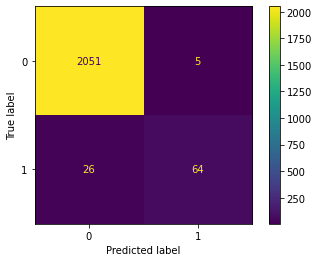

In [43]:
cm = confusion_matrix(y_val, yhat_val1, labels=clf1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf1.classes_)
disp.plot()
plt.show()

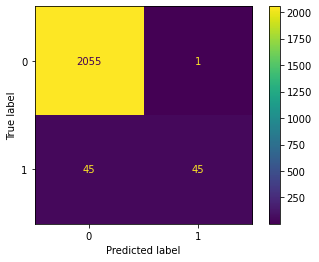

In [44]:
cm = confusion_matrix(y_val, yhat_val2, labels=clf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf2.classes_)
disp.plot()
plt.show()

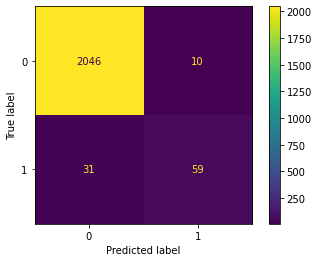

In [45]:
cm = confusion_matrix(y_val, yhat_val3, labels=clf3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf3.classes_)
disp.plot()
plt.show()

The model with the best F1-score in validation is the SVM model. Therefore, we are goign to train the model again, but now using the whole dataset, in order to make the final submission.

## Train on all the dataset

In [216]:
vectorizer = TfidfVectorizer(strip_accents='unicode',
                       analyzer='word',
                       ngram_range=(1, 4),
                       smooth_idf=True,
                        max_features=15000,
                       sublinear_tf=True)

vectorizer.fit(X['text_feature'])

# Transform training
text_vector = vectorizer.transform(X['text_feature'])
rest_train = X.drop(columns=['text_feature'])
X = sp.sparse.hstack((text_vector, rest_train))

pca = PCA(n_components=0.95)
pca.fit(X.toarray())

#Transform training
X = pca.transform(X.toarray())

clf1.fit(X, y)

SVC(C=11, class_weight='balanced', gamma=0.13)

## Create submission

In [217]:
test_data = df_sub

In [218]:
text_vector = vectorizer.transform(test_data['text_feature'])
rest_test = test_data.drop(columns=['text_feature'])
test_data = sp.sparse.hstack((text_vector, rest_test))

test_data = pca.transform(test_data.toarray())

In [219]:
prediction = clf1.predict(test_data)

In [220]:
df_output = pd.DataFrame(prediction)
df_output.index.name = 'Id'
df_output.columns = ['Category']
df_output.to_csv('submission.csv')